In [1]:
import numpy as np
import matplotlib.pyplot as plt

from inner import inner
from utils.entropy import h
from utils.spatial import get_convex_hull
from utils.utils import Source, Channel, Equivocation, InnerParams, ConverseParams, AuxPower

In [2]:
src = Source(Ps = 0.7, Pu = 1.0, Psu = 0.5)
ch  = Channel(P = 1.0, Pn1 = 0.10, Pn2 = 0.15)
eqv = Equivocation(deltaS=h(src.Ps), deltaU=0.0, deltaSU=h(src.Ps))

In [3]:
indirect = False
converse_points = 100
precision = np.float64
eps = np.finfo(precision).eps
R_range = np.linspace(eps, 4.0, converse_points, dtype=precision)
Ds_range = np.geomspace(eps, 1.0, converse_points, dtype=precision)
Du_range = np.geomspace(eps, 2.5, converse_points, dtype=precision)
R, Ds, Du = np.meshgrid(R_range, Ds_range, Du_range, indexing='ij')

In [4]:
aux_grid = np.linspace(0,1,converse_points)

In [5]:
def get_rand_aux_vals(grid, N, target_sum, tolerance=1e-3):
    selected_numbers = np.random.choice(grid, N)
    current_sum = np.sum(selected_numbers)
    
    target_sum -= tolerance
    while abs(current_sum - target_sum) > tolerance:
        difference = target_sum - current_sum
        idx = np.random.randint(0, N)
        selected_numbers[idx] += difference / N 
        selected_numbers[idx] = np.clip(selected_numbers[idx], grid.min(), grid.max())
        current_sum = np.sum(selected_numbers)
    
    return selected_numbers

In [6]:
converse = ConverseParams(R, Ds, Du, eqv, src, ch, indirect=indirect)

#grid_points = 20
iterations = 6000
coef_grid = np.linspace(eps,1,converse_points)
aux_grid = np.linspace(eps,1,converse_points)


for _ in range(iterations):
    j = np.random.randint(0,len(coef_grid),3)
    aux = AuxPower(*get_rand_aux_vals(aux_grid, 2, 1.0), *get_rand_aux_vals(aux_grid, 4, ch.P))
    
    params = InnerParams(converse, aux, coef_grid[j[0]], coef_grid[j[1]], coef_grid[j[2]])
    if 'mask' in locals():
        mask = np.logical_or(mask, inner(params))
    else:
        mask = inner(params)

In [7]:
hull, points = get_convex_hull(mask, R_range, Ds_range, Du_range)
hull = hull[:-1,:]
#hull = np.append(hull, [[4.01,1.00,0.05], [4.01,0.23,2.5],[2.5,0.23,2.0],[2.5,0.23,1.8],[2.5,0.23,1.5]],axis=0)

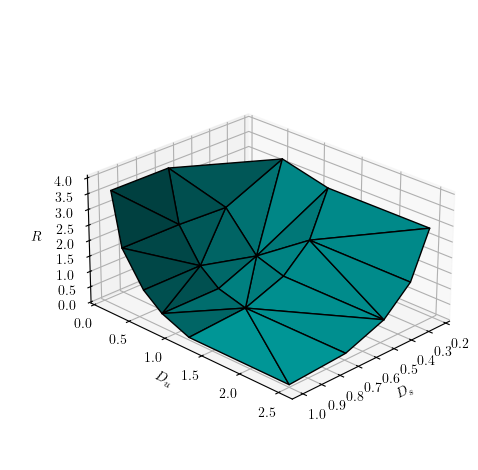

In [8]:
import matplotlib
%matplotlib inline
plt.rcParams['text.usetex'] = True

x_scale=1.2
y_scale=1.5
z_scale=1.0

from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

light = matplotlib.colors.LightSource(170,20)

fig = plt.figure() 
ax = plt.axes(projection="3d")
ax.get_proj = short_proj
ax.view_init(elev=25, azim=45, roll=0)
ax.plot_trisurf(hull[:,1],hull[:,2],hull[:,0], color='c', shade=True, edgecolor='k', linewidth=1, antialiased=True, lightsource=light)
ax.set_xlabel('$D_s$'); ax.set_ylabel('$D_u$'); ax.set_zlabel('$R$')
plt.tight_layout()
#plt.savefig('inner.pdf')
plt.show()